In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Admin\Desktop\Final_Year_Emotion_detection_project\emotions_balanced.csv")

In [13]:
df['label'] = df['label'].astype(int)

In [ ]:
df['label'].value_counts()



2

label
3    50000
1    50000
0    50000
4    47712
2    34554
Name: count, dtype: int64

In [15]:

# Split dataset into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [16]:

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [17]:

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=32)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 58067/58067 [00:21<00:00, 2639.73 examples/s]


In [18]:
# Format datasets for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [19]:
print(train_dataset[0])

{'label': tensor(0), 'input_ids': tensor([ 101, 1045, 2228, 2057, 2035, 2514, 5236, 2043, 2027, 2707, 5948, 2153,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])}


In [20]:

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:

for name, param in model.bert.named_parameters():
    if not any(layer in name for layer in ['encoder.layer.9','encoder.layer.10', 'encoder.layer.11']):
        param.requires_grad = False

In [22]:
# Define the metric function to compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [23]:
training_args = TrainingArguments(
    output_dir='./results',          
    evaluation_strategy="epoch",     
    save_strategy="epoch",           
    learning_rate=1e-5,              
    per_device_train_batch_size=64, 
    per_device_eval_batch_size=64,  
    num_train_epochs=4,             
    weight_decay=0.01,              
    logging_dir='./logs',           
    logging_steps=1000,
    load_best_model_at_end=True,     
    metric_for_best_model="accuracy" 
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset,           
    tokenizer=tokenizer,                 
    compute_metrics=compute_metrics,     
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  
    
)
# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

c:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  0%|          | 0/10888 [00:00<?, ?it/s]c:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  9%|▉         | 1000/10888 [05:37<55:24,  2.97it/s] 

{'loss': 0.951, 'grad_norm': 3.004081964492798, 'learning_rate': 9.081557678177812e-06, 'epoch': 0.37}


 18%|█▊        | 2000/10888 [11:16<50:47,  2.92it/s]

{'loss': 0.5076, 'grad_norm': 3.9521374702453613, 'learning_rate': 8.163115356355622e-06, 'epoch': 0.73}


                                                    
 25%|██▌       | 2722/10888 [19:05<44:36,  3.05it/s]

{'eval_loss': 0.32584527134895325, 'eval_accuracy': 0.892004064270584, 'eval_precision': 0.8933139588050225, 'eval_recall': 0.892004064270584, 'eval_f1': 0.8918147309691942, 'eval_runtime': 222.1284, 'eval_samples_per_second': 261.412, 'eval_steps_per_second': 4.088, 'epoch': 1.0}


 28%|██▊       | 3000/10888 [20:40<44:57,  2.92it/s]    

{'loss': 0.3969, 'grad_norm': 3.79526686668396, 'learning_rate': 7.244673034533431e-06, 'epoch': 1.1}


 37%|███▋      | 4000/10888 [26:23<39:16,  2.92it/s]

{'loss': 0.3497, 'grad_norm': 2.841702461242676, 'learning_rate': 6.326230712711242e-06, 'epoch': 1.47}


 46%|████▌     | 5000/10888 [32:06<33:45,  2.91it/s]

{'loss': 0.3241, 'grad_norm': 3.629195213317871, 'learning_rate': 5.407788390889053e-06, 'epoch': 1.84}


                                                    
 50%|█████     | 5444/10888 [38:21<29:54,  3.03it/s]

{'eval_loss': 0.25544852018356323, 'eval_accuracy': 0.9093633216801281, 'eval_precision': 0.9104292044914166, 'eval_recall': 0.9093633216801281, 'eval_f1': 0.9092960028808383, 'eval_runtime': 223.5558, 'eval_samples_per_second': 259.743, 'eval_steps_per_second': 4.062, 'epoch': 2.0}


 55%|█████▌    | 6000/10888 [41:36<28:47,  2.83it/s]    

{'loss': 0.2967, 'grad_norm': 2.8262152671813965, 'learning_rate': 4.489346069066863e-06, 'epoch': 2.2}


 64%|██████▍   | 7000/10888 [47:28<22:19,  2.90it/s]

{'loss': 0.2875, 'grad_norm': 3.64027738571167, 'learning_rate': 3.5709037472446732e-06, 'epoch': 2.57}


 73%|███████▎  | 8000/10888 [53:12<16:30,  2.92it/s]

{'loss': 0.2842, 'grad_norm': 2.7956275939941406, 'learning_rate': 2.6524614254224833e-06, 'epoch': 2.94}


                                                    
 75%|███████▌  | 8166/10888 [57:53<14:57,  3.03it/s]

{'eval_loss': 0.23246684670448303, 'eval_accuracy': 0.9145297673377305, 'eval_precision': 0.9150755282012076, 'eval_recall': 0.9145297673377305, 'eval_f1': 0.9145303603478394, 'eval_runtime': 224.1936, 'eval_samples_per_second': 259.004, 'eval_steps_per_second': 4.05, 'epoch': 3.0}


 83%|████████▎ | 9000/10888 [1:02:40<10:45,  2.93it/s] 

{'loss': 0.268, 'grad_norm': 3.4861955642700195, 'learning_rate': 1.734019103600294e-06, 'epoch': 3.31}


 92%|█████████▏| 10000/10888 [1:08:23<05:05,  2.91it/s]

{'loss': 0.264, 'grad_norm': 3.7434287071228027, 'learning_rate': 8.155767817781044e-07, 'epoch': 3.67}


                                                       
100%|██████████| 10888/10888 [1:17:12<00:00,  3.02it/s]

{'eval_loss': 0.22841623425483704, 'eval_accuracy': 0.9162519158902647, 'eval_precision': 0.9169958043998999, 'eval_recall': 0.9162519158902647, 'eval_f1': 0.9162253919969252, 'eval_runtime': 223.8583, 'eval_samples_per_second': 259.392, 'eval_steps_per_second': 4.056, 'epoch': 4.0}


100%|██████████| 10888/10888 [1:17:14<00:00,  2.35it/s]


{'train_runtime': 4634.2354, 'train_samples_per_second': 150.358, 'train_steps_per_second': 2.349, 'train_loss': 0.38223224979039067, 'epoch': 4.0}


100%|██████████| 908/908 [03:43<00:00,  4.07it/s]


In [24]:
predictions, true_labels, _ = trainer.predict(val_dataset)
predictions = predictions.argmax(axis=-1)

print(classification_report(true_labels, predictions, target_names=[str(i) for i in range(5)]))

100%|██████████| 908/908 [03:42<00:00,  4.08it/s]

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     12500
           1       0.93      0.88      0.90     12500
           2       0.87      0.94      0.90      8639
           3       0.92      0.92      0.92     12500
           4       0.92      0.94      0.93     11928

    accuracy                           0.92     58067
   macro avg       0.91      0.92      0.92     58067
weighted avg       0.92      0.92      0.92     58067



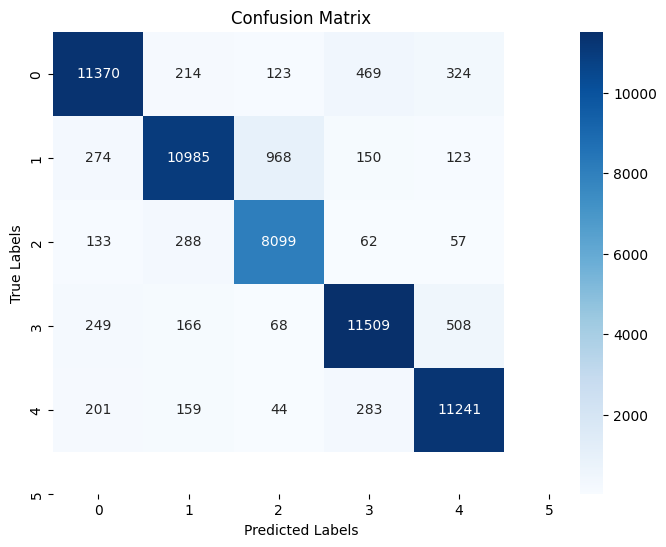

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

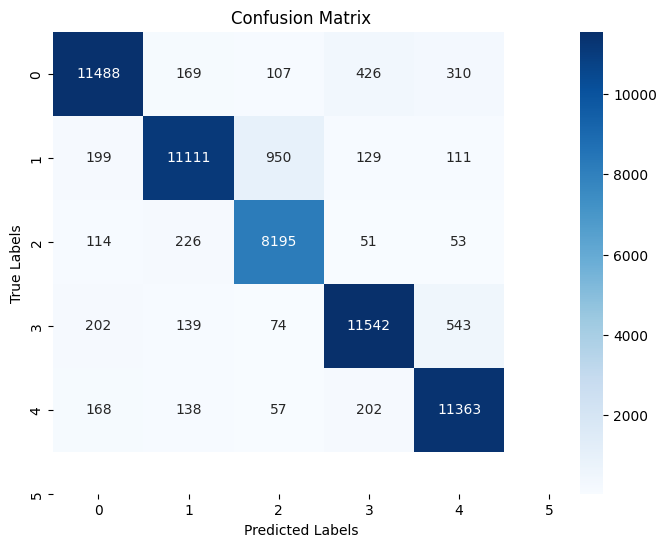

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(6)], yticklabels=[str(i) for i in range(6)])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:

# Save the model and tokenizer
model.save_pretrained("emotion_classifier")
tokenizer.save_pretrained("emotion_classifier")


('emotion_classifier\\tokenizer_config.json',
 'emotion_classifier\\special_tokens_map.json',
 'emotion_classifier\\vocab.txt',
 'emotion_classifier\\added_tokens.json')

In [ ]:
# Save tokenized train and validation datasets
train_dataset.save_to_disk("emotion_train_dataset_12")
val_dataset.save_to_disk("emotion_val_dataset_12")

Saving the dataset (1/1 shards): 100%|██████████| 58067/58067 [00:00<00:00, 886376.84 examples/s]


In [ ]:
# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained("emotion_classifier")
tokenizer = BertTokenizer.from_pretrained("emotion_classifier")

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,  # Total number of epochs (previous + new)
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=800,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Initialize the Trainer with the reloaded model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

# Continue training
trainer.train()


c:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  7%|▋         | 800/10888 [04:30<56:19,  2.98it/s]  

{'loss': 0.2638, 'grad_norm': 2.0126280784606934, 'learning_rate': 9.26524614254225e-06, 'epoch': 0.29}


 15%|█▍        | 1600/10888 [09:00<52:13,  2.96it/s]

{'loss': 0.2411, 'grad_norm': 3.289964199066162, 'learning_rate': 8.530492285084497e-06, 'epoch': 0.59}


 22%|██▏       | 2400/10888 [13:31<47:54,  2.95it/s]

{'loss': 0.2357, 'grad_norm': 2.7154462337493896, 'learning_rate': 7.795738427626746e-06, 'epoch': 0.88}


 25%|██▌       | 2722/10888 [19:02<44:40,  3.05it/s]

{'eval_loss': 0.22266992926597595, 'eval_accuracy': 0.9199545352782131, 'eval_precision': 0.9212075608320853, 'eval_recall': 0.9199545352782131, 'eval_f1': 0.9199292857400513, 'eval_runtime': 221.7919, 'eval_samples_per_second': 261.808, 'eval_steps_per_second': 4.094, 'epoch': 1.0}


 29%|██▉       | 3200/10888 [21:48<43:32,  2.94it/s]    

{'loss': 0.2183, 'grad_norm': 2.7985129356384277, 'learning_rate': 7.060984570168994e-06, 'epoch': 1.18}


 37%|███▋      | 4000/10888 [26:20<38:54,  2.95it/s]

{'loss': 0.2151, 'grad_norm': 2.781752347946167, 'learning_rate': 6.326230712711242e-06, 'epoch': 1.47}


 44%|████▍     | 4800/10888 [30:52<34:31,  2.94it/s]

{'loss': 0.2097, 'grad_norm': 2.8891234397888184, 'learning_rate': 5.59147685525349e-06, 'epoch': 1.76}


 50%|█████     | 5444/10888 [38:13<29:42,  3.05it/s]

{'eval_loss': 0.20819886028766632, 'eval_accuracy': 0.9227788589043691, 'eval_precision': 0.9240440932943363, 'eval_recall': 0.9227788589043691, 'eval_f1': 0.9227808977899835, 'eval_runtime': 221.5745, 'eval_samples_per_second': 262.065, 'eval_steps_per_second': 4.098, 'epoch': 2.0}


 51%|█████▏    | 5600/10888 [39:08<29:56,  2.94it/s]    

{'loss': 0.2079, 'grad_norm': 4.030060768127441, 'learning_rate': 4.856722997795738e-06, 'epoch': 2.06}


 59%|█████▉    | 6400/10888 [43:40<25:27,  2.94it/s]

{'loss': 0.2, 'grad_norm': 4.913171291351318, 'learning_rate': 4.121969140337987e-06, 'epoch': 2.35}


 66%|██████▌   | 7200/10888 [48:12<20:47,  2.96it/s]

{'loss': 0.2034, 'grad_norm': 2.6692562103271484, 'learning_rate': 3.387215282880235e-06, 'epoch': 2.65}


 73%|███████▎  | 8000/10888 [52:45<16:29,  2.92it/s]

{'loss': 0.2099, 'grad_norm': 2.7464661598205566, 'learning_rate': 2.6524614254224833e-06, 'epoch': 2.94}


 75%|███████▌  | 8166/10888 [57:23<14:49,  3.06it/s]

{'eval_loss': 0.19870994985103607, 'eval_accuracy': 0.9238982554635163, 'eval_precision': 0.9249518352340474, 'eval_recall': 0.9238982554635163, 'eval_f1': 0.9239550823844718, 'eval_runtime': 222.0223, 'eval_samples_per_second': 261.537, 'eval_steps_per_second': 4.09, 'epoch': 3.0}


 81%|████████  | 8800/10888 [1:01:02<11:52,  2.93it/s] 

{'loss': 0.1981, 'grad_norm': 2.6672306060791016, 'learning_rate': 1.917707567964732e-06, 'epoch': 3.23}


 88%|████████▊ | 9600/10888 [1:05:35<07:17,  2.94it/s]

{'loss': 0.2005, 'grad_norm': 5.058374881744385, 'learning_rate': 1.1829537105069803e-06, 'epoch': 3.53}


 96%|█████████▌| 10400/10888 [1:10:07<02:46,  2.93it/s]

{'loss': 0.2038, 'grad_norm': 2.1499085426330566, 'learning_rate': 4.4819985304922855e-07, 'epoch': 3.82}


100%|██████████| 10888/10888 [1:16:37<00:00,  3.06it/s]

{'eval_loss': 0.19736433029174805, 'eval_accuracy': 0.9247765512253087, 'eval_precision': 0.9258470863681505, 'eval_recall': 0.9247765512253087, 'eval_f1': 0.9247995595813056, 'eval_runtime': 222.054, 'eval_samples_per_second': 261.499, 'eval_steps_per_second': 4.089, 'epoch': 4.0}


100%|██████████| 10888/10888 [1:16:39<00:00,  2.37it/s]

{'train_runtime': 4599.4881, 'train_samples_per_second': 151.494, 'train_steps_per_second': 2.367, 'train_loss': 0.21537401534283013, 'epoch': 4.0}


TrainOutput(global_step=10888, training_loss=0.21537401534283013, metrics={'train_runtime': 4599.4881, 'train_samples_per_second': 151.494, 'train_steps_per_second': 2.367, 'total_flos': 1.1458729324771584e+16, 'train_loss': 0.21537401534283013, 'epoch': 4.0})

In [30]:

# Save the model and tokenizer
model.save_pretrained("emotion_classifier_8epoch")
tokenizer.save_pretrained("emotion_classifier_8epoch")


('emotion_classifier_8epoch\\tokenizer_config.json',
 'emotion_classifier_8epoch\\special_tokens_map.json',
 'emotion_classifier_8epoch\\vocab.txt',
 'emotion_classifier_8epoch\\added_tokens.json')

In [31]:
predictions, true_labels, _ = trainer.predict(val_dataset)
predictions = predictions.argmax(axis=-1)

print(classification_report(true_labels, predictions, target_names=[str(i) for i in range(5)]))

100%|██████████| 908/908 [03:37<00:00,  4.18it/s]

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     12500
           1       0.94      0.89      0.92     12500
           2       0.87      0.95      0.91      8639
           3       0.93      0.92      0.93     12500
           4       0.92      0.95      0.93     11928

    accuracy                           0.92     58067
   macro avg       0.92      0.93      0.92     58067
weighted avg       0.93      0.92      0.92     58067



In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the model and tokenizer
model_name = "emotion_classifier_8epoch"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)


c:\Users\Admin\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text = "I am very happy today"

# Tokenize and predict
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
predicted_class = outputs.logits.argmax(dim=1).item()

label_to_emotion = {0:'sadness',
                    1: 'joy',
                    2:'love',
                    3: 'anger', 
                    4:'fear' }
emotion = label_to_emotion.get(predicted_class, "Unknown")

# Print the result
print(f"Text: {text}")
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Emotion: {emotion}")

Text: I am very happy today
Predicted Class: 1
Predicted Emotion: joy


In [15]:
# Example sentence to tokenize
example_text = " have the caring brother but i do not like him"

# Tokenize and get tokens as words
tokens = tokenizer.tokenize(example_text)

# Print the tokens
print("Tokens:", tokens)


Tokens: ['have', 'the', 'caring', 'brother', 'but', 'i', 'do', 'not', 'like', 'him']


In [ ]:
example_text = "unbelievably"
tokens = tokenizer.tokenize(example_text)
print("Tokens:", tokens)


Tokens: ['un', '##bel', '##ie', '##va', '##bly']
